## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import qmc
import random
import math

# Set global parameters
matplotlib.rcParams.update({
    'font.size': 12,  # Adjust font size
    'figure.dpi': 300  # Set high resolution for the plot
})

seed = 42
random.seed(seed)
np.random.seed(seed)

## Basic Fully-Connected Network

In [2]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        activation = nn.Tanh

        # Input layer
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())

        # Hidden layers
        hidden_layers = [nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)]
        self.fch = nn.Sequential(*hidden_layers)

        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        for hidden_layer in self.fch:
            x = hidden_layer(x)
        x = self.fce(x)
        return x

# Example usage
N_INPUT = 2
N_OUTPUT = 2
N_HIDDEN = 20
N_LAYERS = 5
pinn = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

## Training

In [14]:
def init_xavier(model, retrain_seed=42):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

def H(phi):
  output = torch.where(phi < 0., 1., 0.)
  return output

def D(phi, epsilon):
  output = torch.where(phi.abs() < epsilon, 1., 0.)
  return output

init_xavier(pinn, seed)

In [3]:
# Constants
X, T = 1.1, 0.5  # domain limits
pin, pout = 1.0, 0.0 # Pressure in, pressure out
N = 2500

N_x = 55
N_t = 50
resolution = X/N_x
epsilon = (1.01/2)*resolution

# Generate a grid of points within the domain
t_values = torch.linspace(0, T, N_t).view(-1, 1)
x_values = torch.linspace(0, X, N_x).view(-1, 1)
t_grid, x_grid = torch.meshgrid(t_values[:, 0], x_values[:, 0], indexing='ij')

# Flatten the grid to pass through the network
t_physics = t_grid.reshape(-1, 1).requires_grad_(True)
x_physics = x_grid.reshape(-1, 1).requires_grad_(True)

# Boundary and initial condition points
x_initial = torch.linspace(0, X, N_x).view(-1, 1)
t_initial = torch.zeros_like(x_initial)

# Linear drop from pin to pout before x = r_in, then continue linearly
r_in = 0.2
gradient = (pout - pin)/r_in

phi_initial = x_initial - r_in
p_initial = gradient*phi_initial

t_boundary = torch.linspace(0, T, N_t).view(-1, 1)
x_left_boundary = torch.zeros_like(t_boundary)

In [15]:
# Initialize a dictionary to store the individual loss components
loss_history = {
    'total_loss': [],
    'p_ic_loss': [],
    'phi_ic_loss': [],
    'inlet_bc_loss': [],
    'front_bc_loss': [],
    'laplace_loss': [],
    'level_set_loss': [],
    'eikonal_loss': []
    }

for iteration in range(10000):
    optimiser.zero_grad()

    losses = []

    # Compute IC loss
    combined_input = torch.cat([t_initial, x_initial], dim=1)
    p, phi = pinn(combined_input).split(1, dim=1)

    p_ic_loss = torch.mean((p - p_initial)**2)
    phi_ic_loss = torch.mean((phi - phi_initial)**2)

    # Compute inlet boundary loss
    combined_input = torch.cat([t_boundary, x_left_boundary], dim=1)
    p, _ = pinn(combined_input).split(1, dim=1)

    inlet_bc_loss = torch.mean((p - pin)**2)

    # Compute physics loss
    combined_input = torch.cat([t_physics, x_physics], dim=1)
    p, phi = pinn(combined_input).split(1, dim=1)

    p_x = torch.autograd.grad(p, x_physics, torch.ones_like(p), create_graph=True)[0]
    p_xx = torch.autograd.grad(p_x, x_physics, torch.ones_like(p_x), create_graph=True)[0]

    front_bc_loss = torch.mean((D(phi, epsilon)*(p - pout))**2)
    laplace_loss = torch.mean(p_xx**2)

    phi_t = torch.autograd.grad(phi, t_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x_physics, torch.ones_like(phi), create_graph=True)[0]

    level_set_loss = torch.mean((phi_t - p_x*phi_x)**2)
    eikonal_loss = torch.mean((phi_x.abs() - 1)**2)

    total_loss = p_ic_loss + phi_ic_loss + inlet_bc_loss + front_bc_loss + laplace_loss + level_set_loss + eikonal_loss
    total_loss.backward()
    optimiser.step()

    loss_history['total_loss'].append(total_loss.item())
    loss_history['p_ic_loss'].append(p_ic_loss.item())
    loss_history['phi_ic_loss'].append(phi_ic_loss.item())
    loss_history['inlet_bc_loss'].append(inlet_bc_loss.item())
    loss_history['front_bc_loss'].append(front_bc_loss.item())
    loss_history['laplace_loss'].append(laplace_loss.item())
    loss_history['level_set_loss'].append(level_set_loss.item())
    loss_history['eikonal_loss'].append(eikonal_loss.item())

    # Record and print the loss every few iterations
    if iteration % 500 == 0:
        print(f"Iteration {iteration}, Total: {total_loss.item()}, IC (p): {p_ic_loss.item()}, IC (phi): {phi_ic_loss.item()}, BC (inlet): {inlet_bc_loss.item()}, BC (front): {front_bc_loss.item()}, Laplace: {laplace_loss.item()}, Level-set: {level_set_loss.item()}, Eikonal: {eikonal_loss.item()}")

Iteration 0, Total: 10.782729148864746, IC (p): 6.156130790710449, IC (phi): 0.41239234805107117, BC (inlet): 0.455363929271698, BC (front): 0.03723433241248131, Laplace: 2.087980031967163, Level-set: 1.0918978452682495, Eikonal: 0.5417296886444092
Iteration 500, Total: 0.022450951859354973, IC (p): 0.0010217424714937806, IC (phi): 5.9666828747140244e-05, BC (inlet): 0.00011068399908253923, BC (front): 0.012008270248770714, Laplace: 0.0066274539567530155, Level-set: 0.001516188494861126, Eikonal: 0.001106946263462305
Iteration 1000, Total: 0.010907369665801525, IC (p): 0.00031103380024433136, IC (phi): 6.90089200361399e-06, BC (inlet): 0.00032730959355831146, BC (front): 0.0075777443125844, Laplace: 0.0018356968648731709, Level-set: 0.0004740168806165457, Eikonal: 0.00037466600770130754
Iteration 1500, Total: 0.004947027191519737, IC (p): 0.00013288066838867962, IC (phi): 3.771629735638271e-06, BC (inlet): 0.00028597094933502376, BC (front): 0.0032874310854822397, Laplace: 0.0007888076

In [ ]:
import os

# Define the directory and filename
save_dir = './Trained Models'
filename = '1D_Level_Set_Laplace_First_Approach.pth'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Path where the model will be saved
save_path = os.path.join(save_dir, filename)

# Save the model state
torch.save(pinn.state_dict(), save_path)

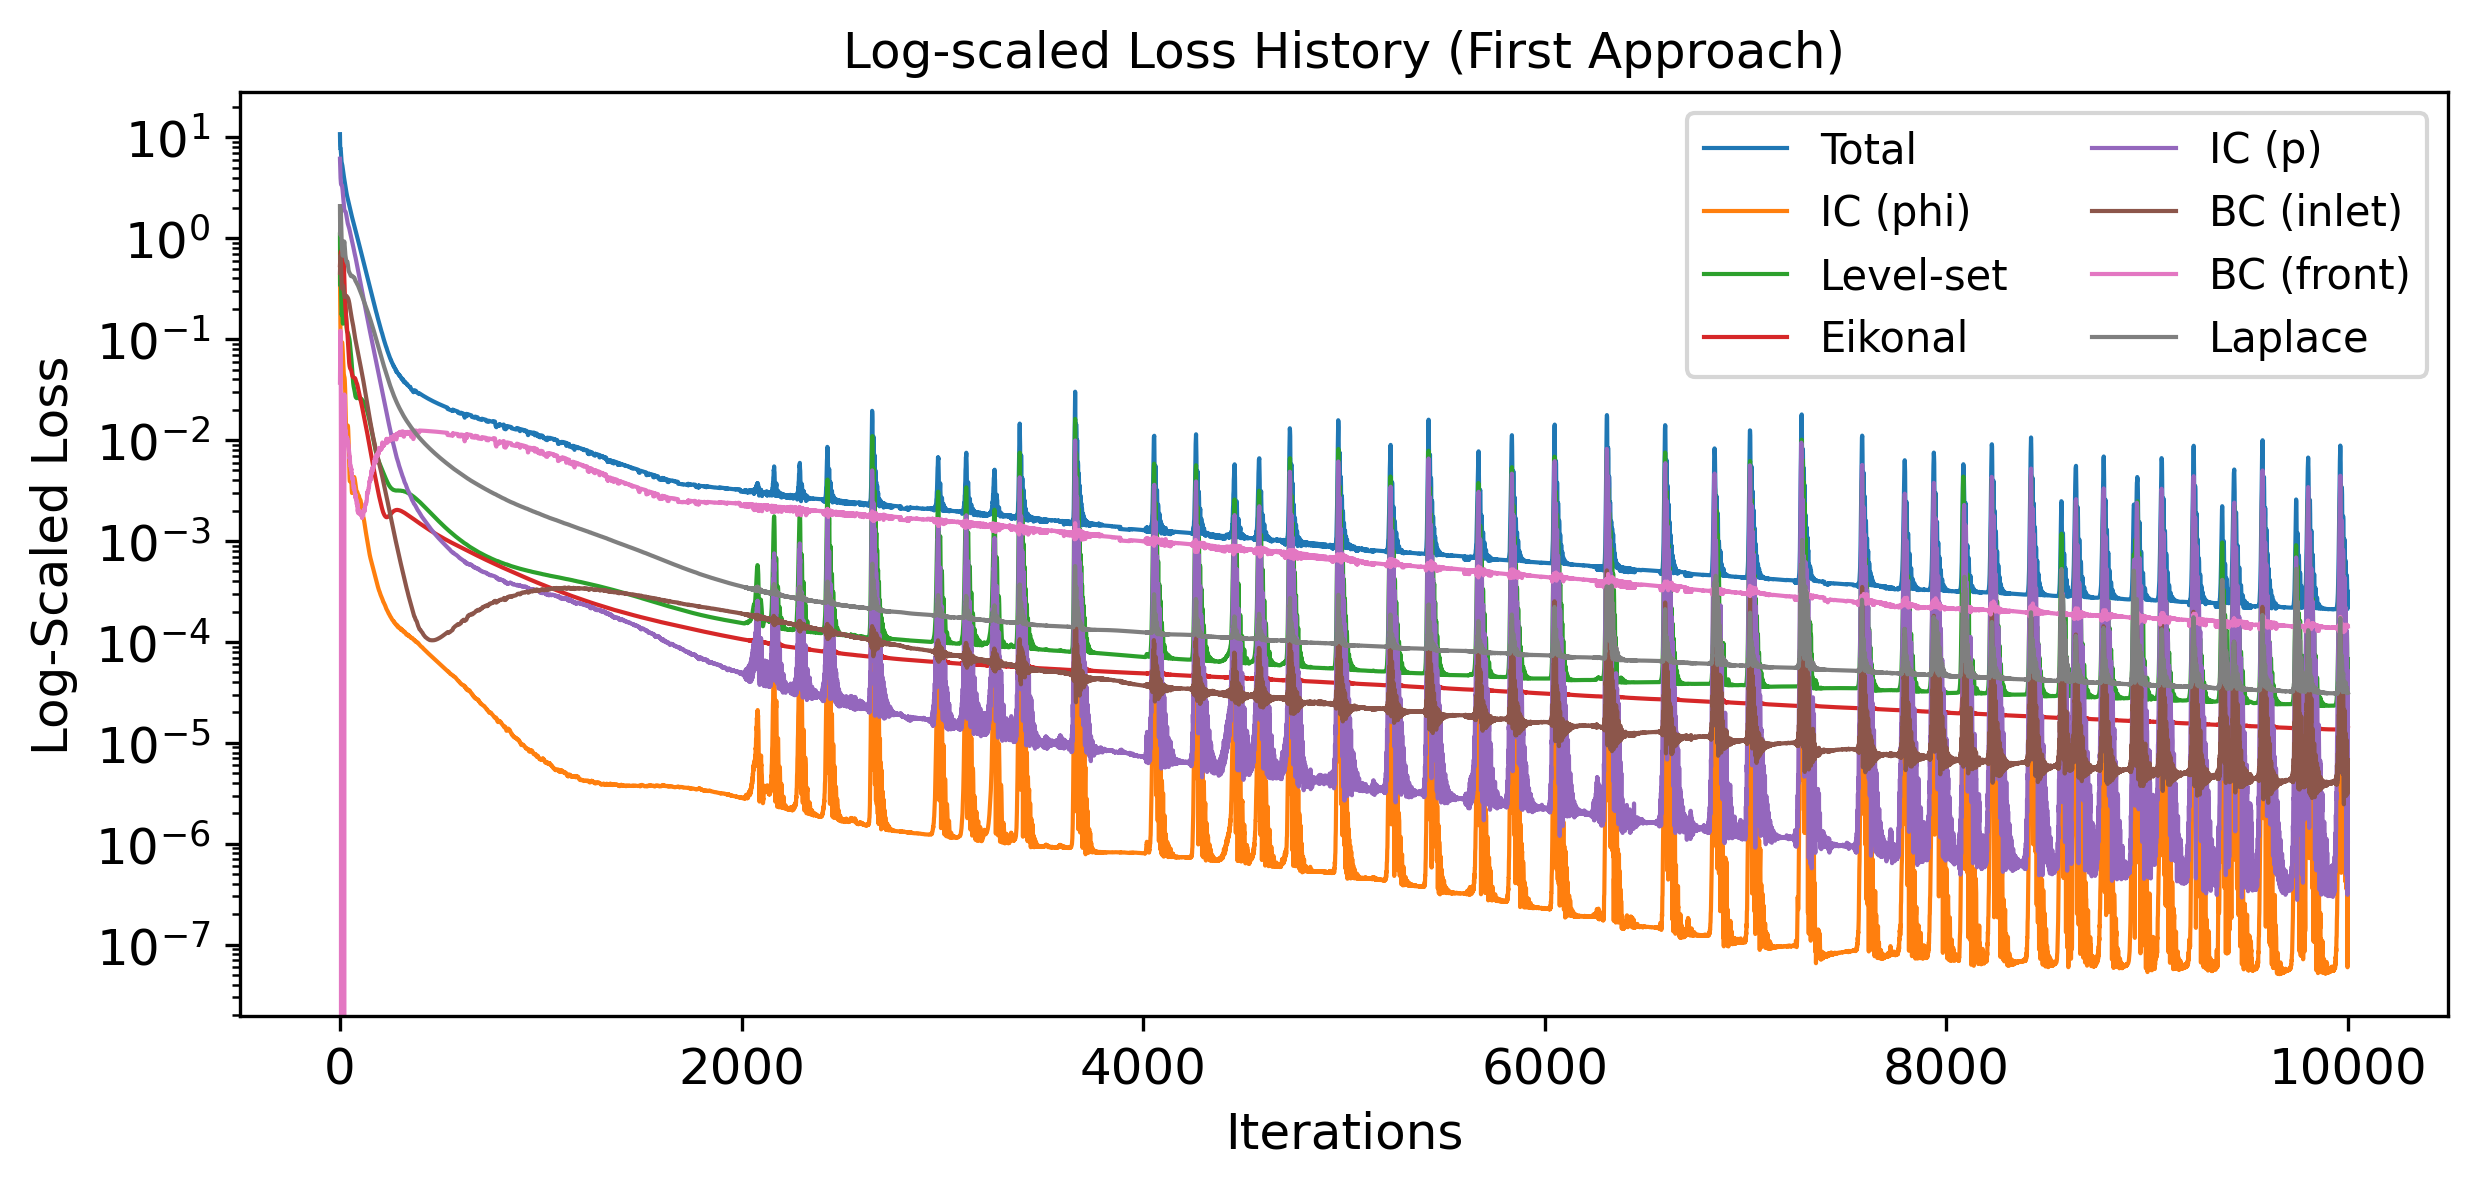

In [16]:
# Define a variable for line width
line_width = 1

# Create a plot with adjusted dimensions
fig, ax = plt.subplots(figsize=(9.5, 4))  # Width in inches to fit A4 page with 20mm margins, height adjusted as needed

# Plot each component of the loss with a logarithmic scale using the line width variable
ax.semilogy(loss_history['total_loss'], label='Total', linewidth=line_width)
ax.semilogy(loss_history['phi_ic_loss'], label='IC (phi)', linewidth=line_width)
ax.semilogy(loss_history['level_set_loss'], label='Level-set', linewidth=line_width)
ax.semilogy(loss_history['eikonal_loss'], label='Eikonal', linewidth=line_width)
ax.semilogy(loss_history['p_ic_loss'], label='IC (p)', linewidth=line_width)
ax.semilogy(loss_history['inlet_bc_loss'], label='BC (inlet)', linewidth=line_width)
ax.semilogy(loss_history['front_bc_loss'], label='BC (front)', linewidth=line_width)
ax.semilogy(loss_history['laplace_loss'], label='Laplace', linewidth=line_width)

# Setting titles and labels with appropriate size
ax.set_title('Log-scaled Loss History (First Approach)', fontsize=12)
ax.set_xlabel('Iterations')
ax.set_ylabel('Log-Scaled Loss')

# Set legend with a readable size
ax.legend(fontsize=10, ncol=2)

plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LAP/first_approach_training.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [4]:
pinn.load_state_dict(torch.load('./Trained Models/1D_Level_Set_Laplace_First_Approach.pth'))

<All keys matched successfully>

In [5]:
# Define the grid for evaluation
N_eval = 1000  # Number of evaluation points
t_eval = torch.linspace(0, T, N_eval).view(-1, 1)  # Time points
x_eval = torch.linspace(0, X, N_eval).view(-1, 1)  # Space points

# Initialise matrices to store the phi and pressure values for each (t, x) pair
pressure_values = np.zeros((N_eval, N_eval))  # Pressure values for each (x, t) pair
phi_values = np.zeros((N_eval, N_eval))  # Phi values for each (x, t) pair

# List for storing flow front positions for each time step
flow_front_positions = np.zeros(N_eval)

# Evaluate the trained model and fill the pressure_values matrix
for i, t in enumerate(t_eval):
    t_repeated = t.repeat(N_eval, 1)
    combined_input = torch.cat([t_repeated, x_eval], dim=1)
    p_pred, phi_pred = pinn(combined_input).split(1, dim=1)
    p_pred = p_pred.detach().numpy().flatten()  # Convert to numpy for processing
    phi_pred = phi_pred.detach().numpy().flatten()  # Convert to numpy for processing

    # Store the phi predictions
    phi_values[:, i] = phi_pred

    # Store the pressure predictions
    pressure_values[:, i] = p_pred

    # Detect flow front (where phi_pred is closest to zero)
    idx = np.argmin(np.abs(phi_pred))  # Index where phi is closest to zero
    flow_front_positions[i] = x_eval[idx]

# Find the maximum absolute values for centering the colormaps
max_abs_phi = np.max(np.abs(phi_values))
max_abs_p = np.max(np.abs(pressure_values))

In [6]:
# Given parameters
k = 1.0  # Permeability
mu = 1.0  # Viscosity
p_in = 1  # Inlet pressure
p_out = 0   # Outlet pressure
d = 0.2       # Initial position of the flow front
L = 1     # Length of the porous medium
# Compute pressures for a grid of x and t
x, t = np.meshgrid(x_eval, t_eval)

# Analytical solution for s(t)
def s_t(t, k, mu, p_in, p_out, d):
    return np.sqrt(2 * k / mu * (p_in - p_out) * t + d**2)

def analytical_pressure(x, t, p_in, p_out, k, mu, d, L):
  # Calculate the current position of the flow front
  s = s_t(t, k, mu, p_in, p_out, d)
  # Pressure distribution
  pressure = np.where(x <= s,
  p_in + (p_out - p_in) * (x / s),
  p_out)
  return pressure

# Calculate the analytical solution over the same t_eval
analytical_positions = s_t(t_eval.numpy(), k, mu, p_in, p_out, d)

pressures = analytical_pressure(x, t, p_in, p_out, k, mu, d, L)

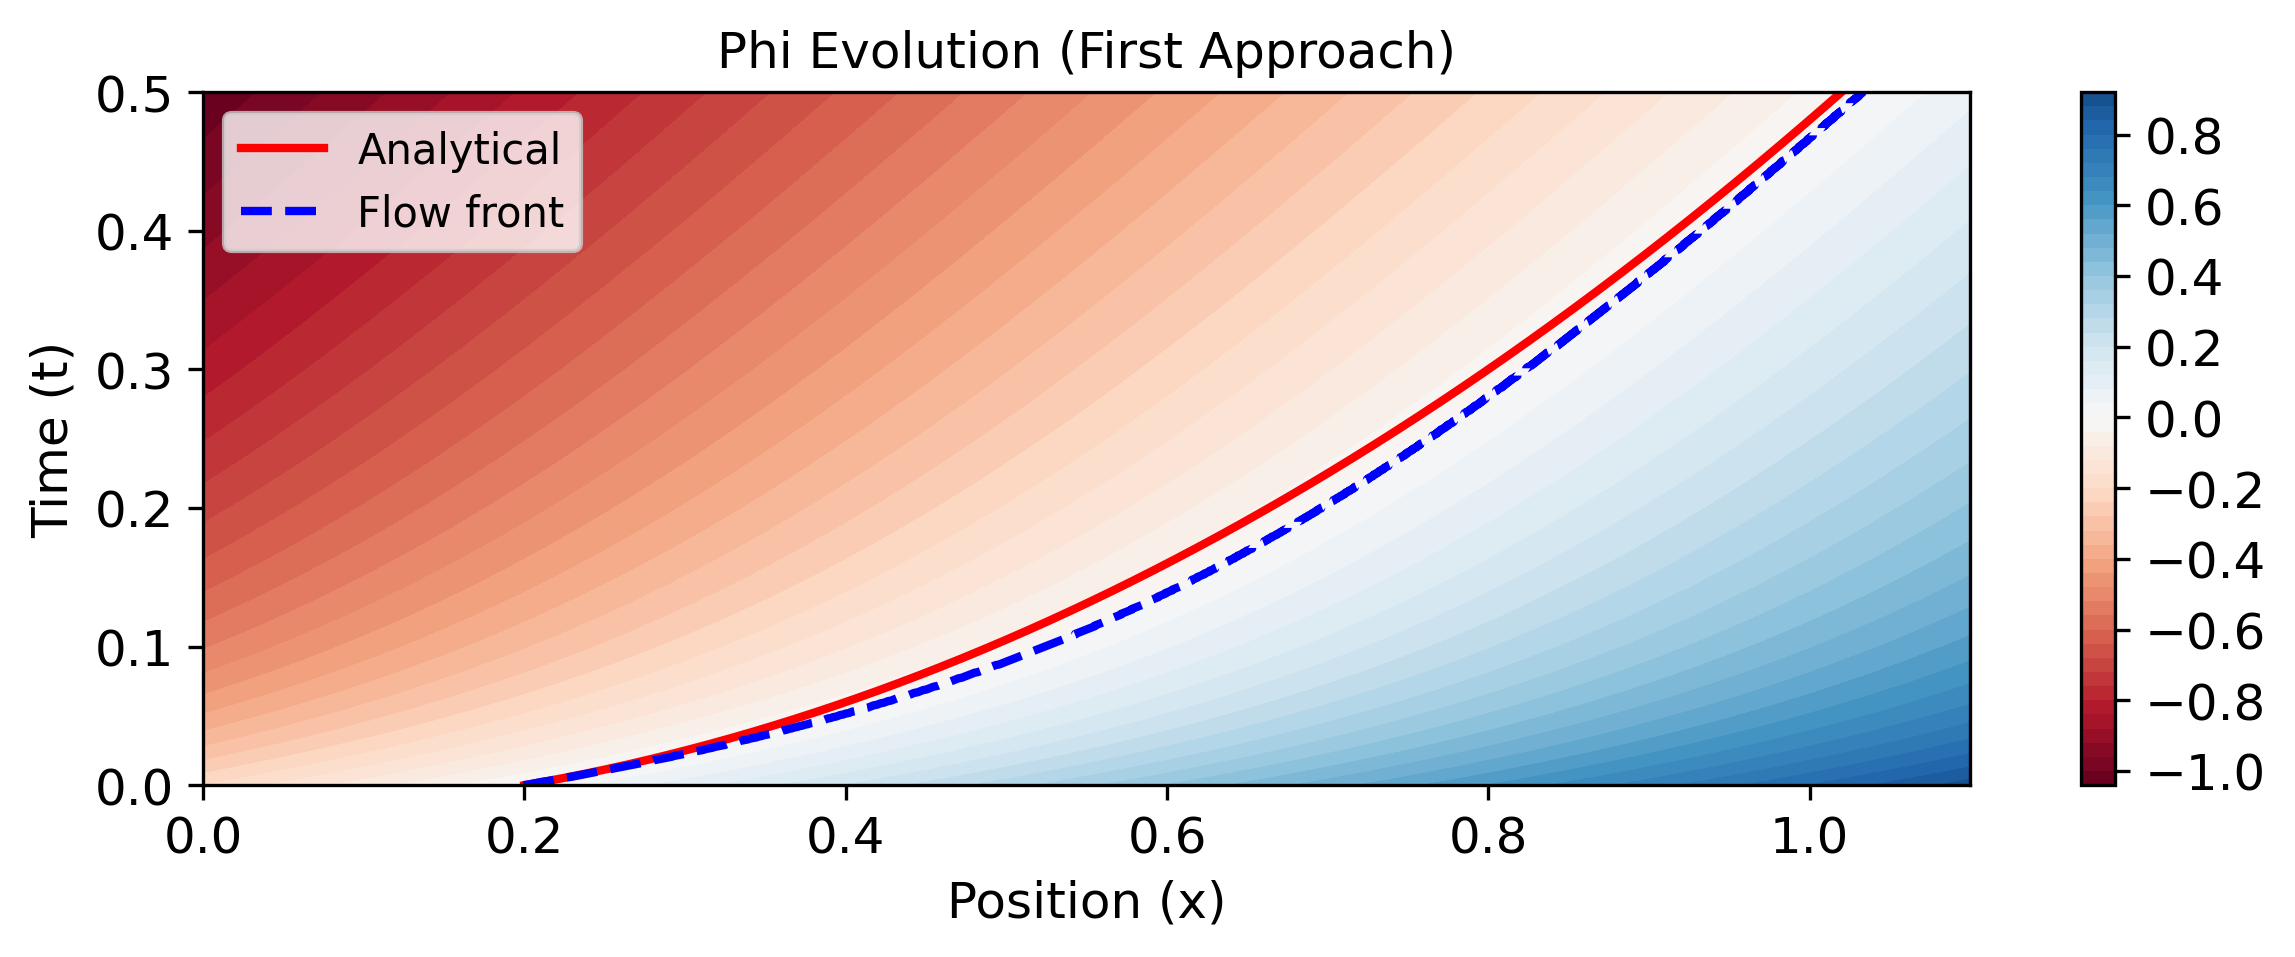

In [8]:
plt.figure(figsize=[9.5, 3])
plt.contourf(x_eval.numpy().flatten(), t_eval.numpy().flatten(), phi_values.T, 50, cmap='RdBu', vmin=-max_abs_phi, vmax=max_abs_phi)
plt.colorbar()
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')

# Overlay the analytical solution
plt.plot(analytical_positions, t_eval.numpy(), 'r-', linewidth=2, label='Analytical')
# Overlay the flow front curve
plt.plot(flow_front_positions, t_eval.numpy().flatten(), 'b--', linewidth=2, label='Flow front')
plt.legend(fontsize=10)
plt.title('Phi Evolution (First Approach)', fontsize=12)
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LAP/first_approach_phi.png', bbox_inches='tight', dpi=300)
plt.show()

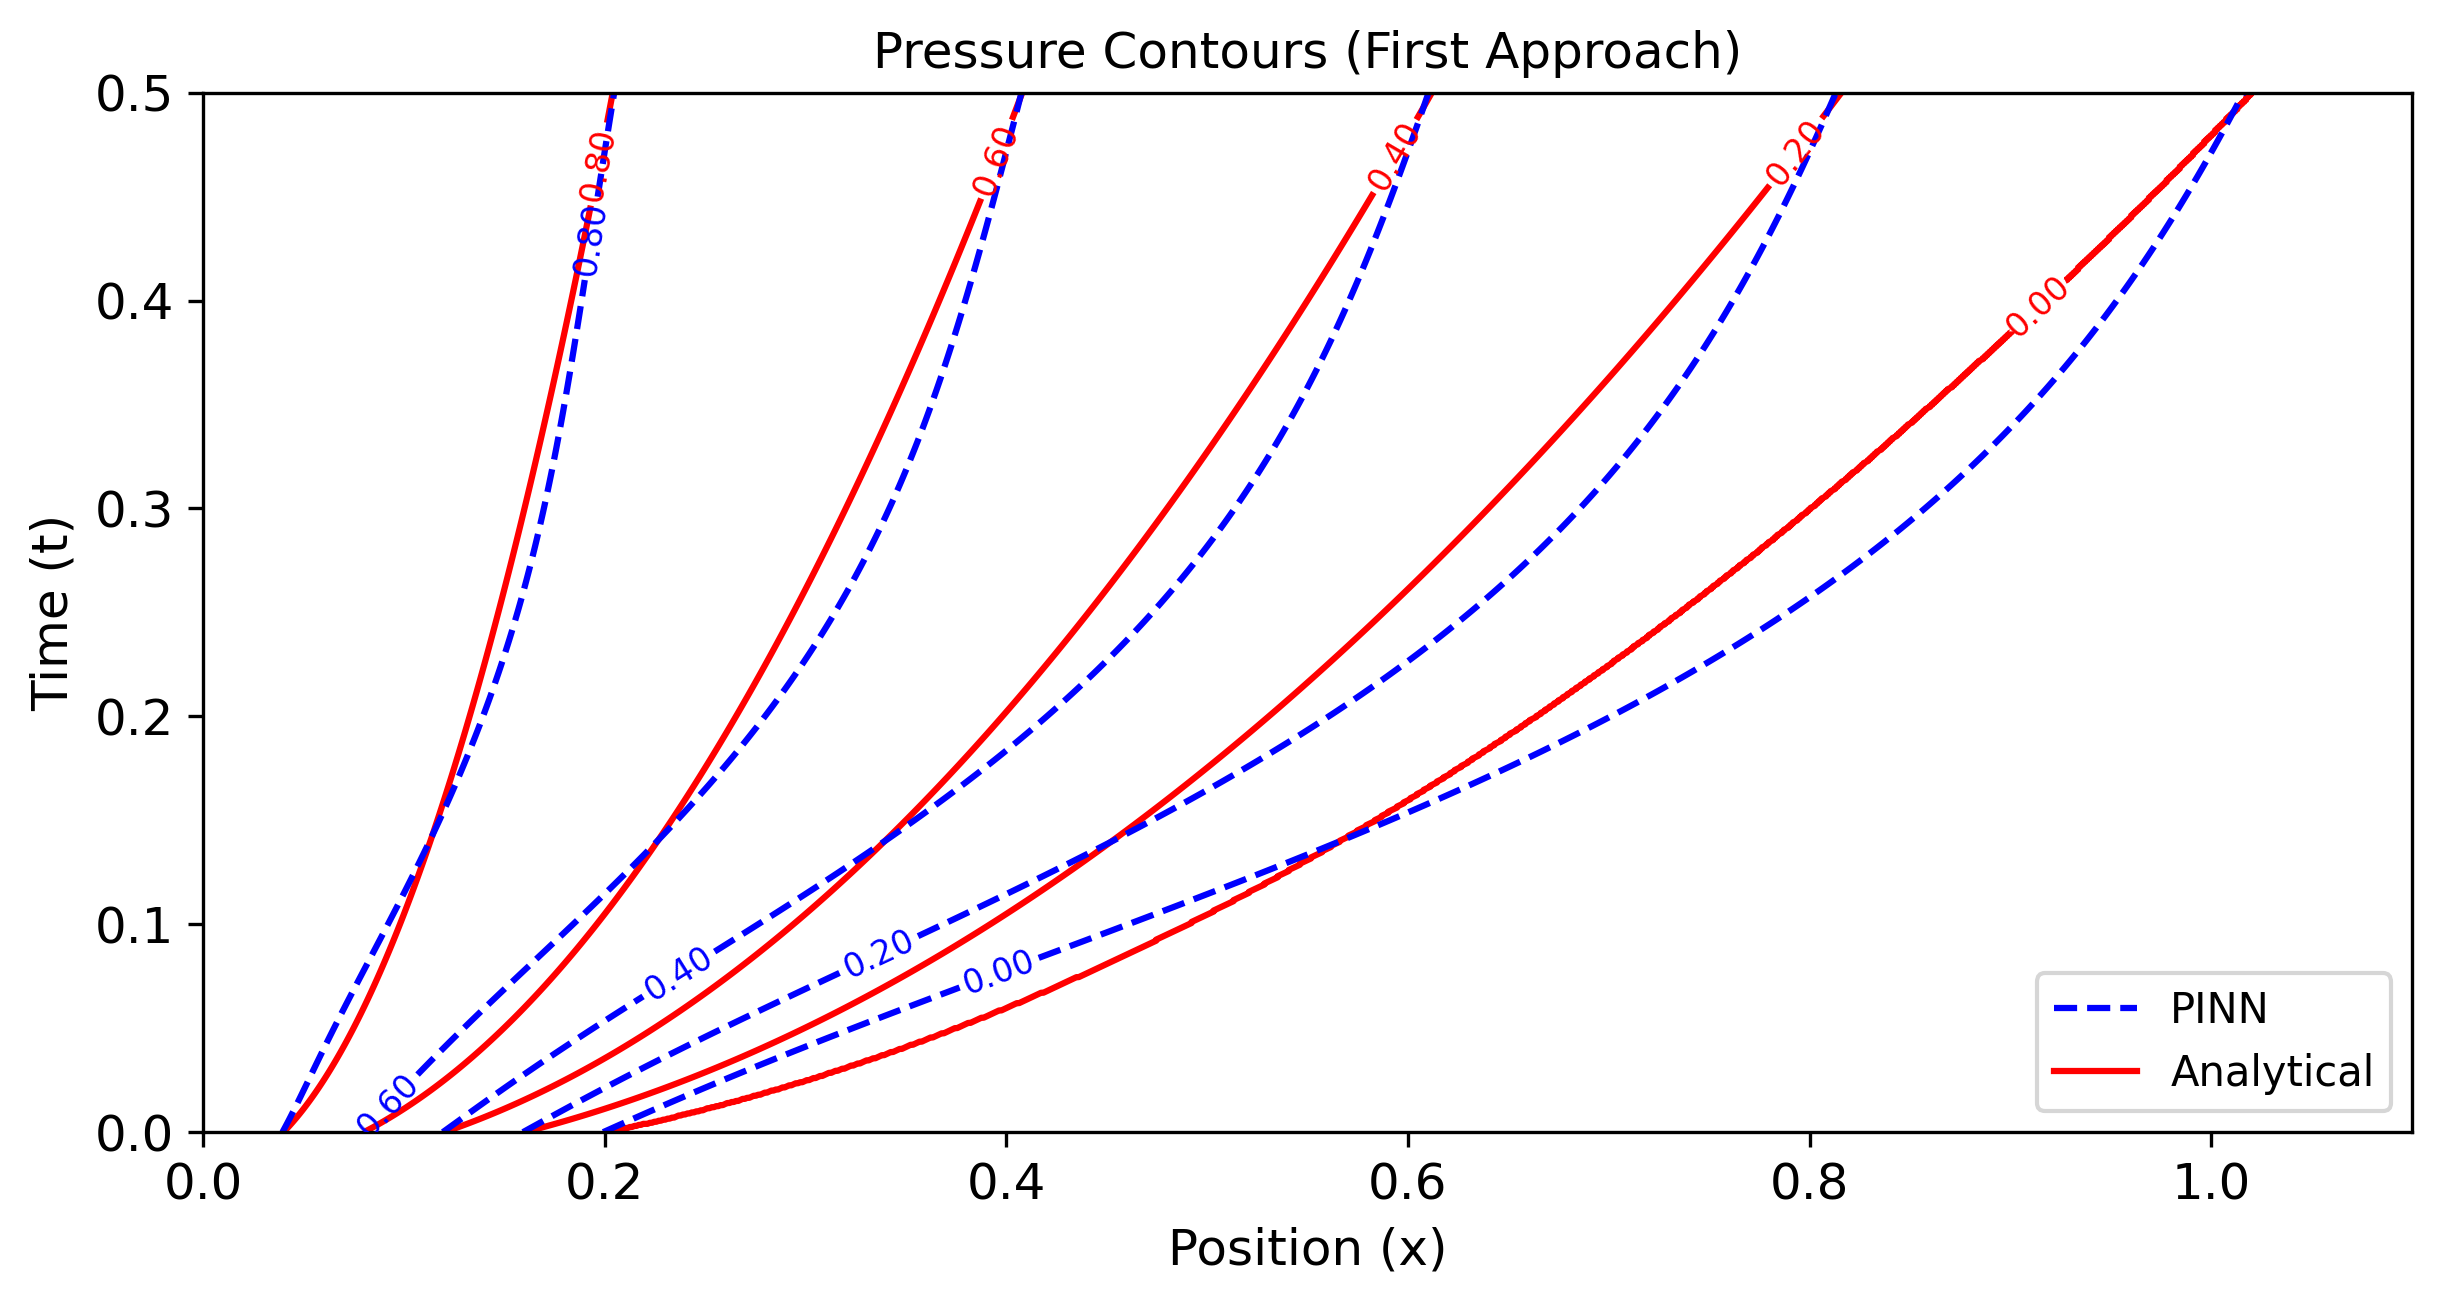

In [11]:
import matplotlib.lines as mlines

plt.figure(figsize=[9.5, 4.5])

# Overlay the analytical pressure contours
contour_lines_analytical = plt.contour(x_eval.numpy().flatten(), t_eval.numpy().flatten(), pressures, levels=[0, 0.2, 0.4, 0.6, 0.8], colors='r', linestyles='-')
plt.clabel(contour_lines_analytical, inline=True, fontsize=8, fmt='%1.2f', colors='red')

# Draw contour lines for specific pressure values from PINN
contour_lines_pinn = plt.contour(x_eval.numpy().flatten(), t_eval.numpy().flatten(), pressure_values.T, levels=[0, 0.2, 0.4, 0.6, 0.8], colors='b', linestyles='--')
plt.clabel(contour_lines_pinn, inline=True, fontsize=8, fmt='%1.2f')

# Labels and title
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.title('Pressure Contours (First Approach)', fontsize=12)

# Creating custom handles for the legend
pinn_handle = mlines.Line2D([], [], color='blue', linestyle='--', label='PINN')
analytical_handle = mlines.Line2D([], [], color='red', linestyle='-', label='Analytical')

# Adding the legend
plt.legend(handles=[pinn_handle, analytical_handle], loc='lower right', fontsize=10)

plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LAP/first_approach_p.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

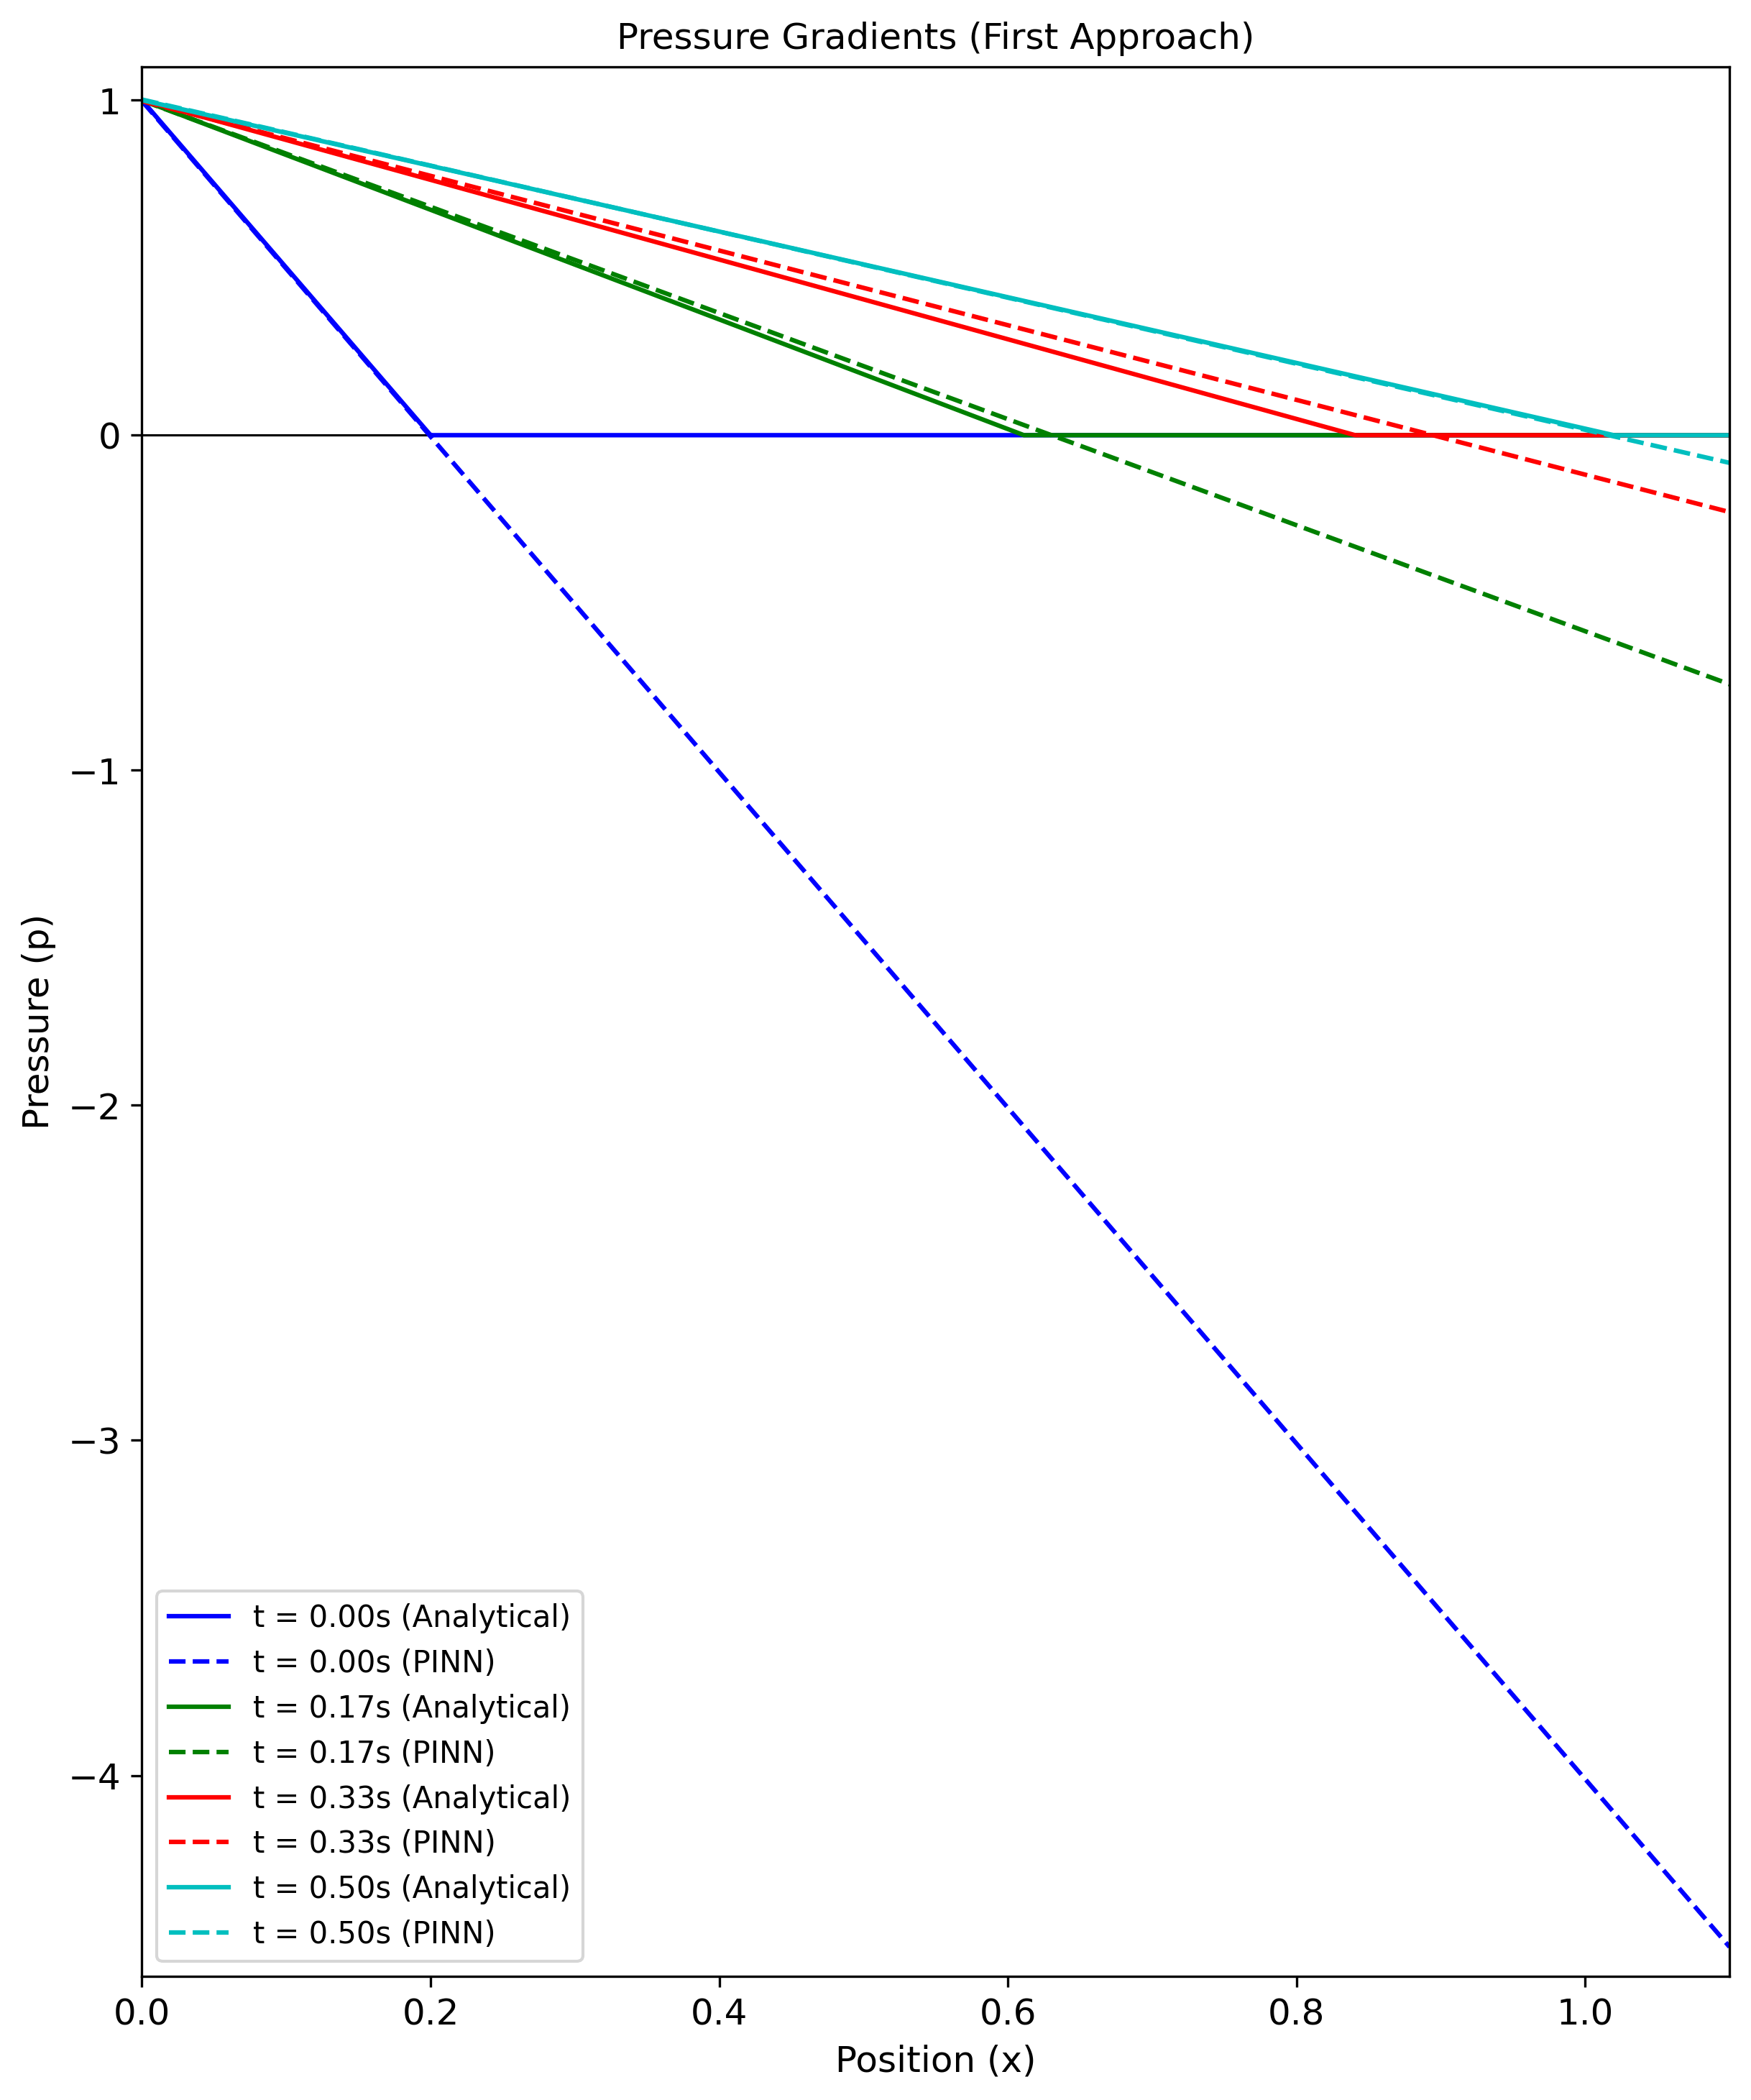

In [7]:
# Adjusting time indices to include the first, last, and two evenly distributed times in between
time_indices = [0, N_eval // 3, 2 * N_eval // 3, N_eval - 1]  # Improved distribution
colors = ['b', 'g', 'r', 'c']  # Define a list of colors for the plots and vertical lines
labels = ['t', 't', 't', 't']  # Simple labels for the legend

plt.figure(figsize=(9.5, 11.5))

# Add a horizontal line at p = pout
plt.axhline(y=pout, color='k', linewidth=0.75, linestyle='-')

for idx, color, label in zip(time_indices, colors, labels):
    # Plot pressure values
    plt.plot(x_eval.flatten(), pressures.T[:, idx], label=f'{label} = {t_eval[idx].item():.2f}s (Analytical)', color=color)
    plt.plot(x_eval.flatten(), pressure_values[:, idx], label=f'{label} = {t_eval[idx].item():.2f}s (PINN)', linestyle='--', color=color)

plt.xlabel('Position (x)')
plt.xlim([0, 1.1])
plt.ylim([-4.6, 1.1])
plt.ylabel('Pressure (p)')
plt.title('Pressure Gradients (First Approach)', fontsize=12)
plt.legend(fontsize=10)
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/1D_LAP/first_approach_pg.png', bbox_inches='tight', dpi=300)
plt.show()